# Imports

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.set_option('display.max_columns', 250)


In [129]:
df = pd.read_csv('../data/clean_final.csv')

In [3]:
df.head()

,index,Id,CreationDate,Title,Body,Tags,ViewCount,AnswerCount,CommentCount,target_tags,overlap_tags,target_class,body_clean
0,1,53992219,2019-01-01 00:01:55,How to programmatically change style sheet of ...,<p>I have so many buttons on a dialog and I wa...,"['c++', 'qt', 'qt5', 'qtstylesheets', 'qpushbu...",775,2,2,{'c++'},c++,4,i have so many buttons on a dialog and i want ...
1,4,53992223,2019-01-01 00:02:37,Unable to print a class list attribute using i...,<p>I am designing a deck class that has <stron...,"['python', 'python-3.x', 'list', 'class', 'pri...",40,2,0,"{'python-3.x', 'python'}",python-3.x python,5,i am designing a deck class that has init meth...
2,8,53992234,2019-01-01 00:05:48,How to rearrange subplots so that one is under...,<p>I am trying to code two plots such that one...,"['python', 'matplotlib', 'subplot']",519,1,1,{'python'},python,5,i am trying to code two plots such that one pl...
3,10,53992248,2019-01-01 00:09:24,Function always returns 1,<p>I´m trying to write a simple branch predict...,"['c++', 'function']",150,1,21,{'c++'},c++,4,i m trying to write a simple branch predictor ...
4,11,53992252,2019-01-01 00:11:20,possible to speed up this query?,<p>I have the following query which takes a li...,"['sql', 'postgresql']",40,1,0,{'sql'},sql,0,i have the following query which takes a littl...


In [130]:
# Drop random and unnecesary'index' labeled column 
df = df.drop(['index'], axis = 1)

In [5]:
df.head()

,Id,CreationDate,Title,Body,Tags,ViewCount,AnswerCount,CommentCount,target_tags,overlap_tags,target_class,body_clean
0,53992219,2019-01-01 00:01:55,How to programmatically change style sheet of ...,<p>I have so many buttons on a dialog and I wa...,"['c++', 'qt', 'qt5', 'qtstylesheets', 'qpushbu...",775,2,2,{'c++'},c++,4,i have so many buttons on a dialog and i want ...
1,53992223,2019-01-01 00:02:37,Unable to print a class list attribute using i...,<p>I am designing a deck class that has <stron...,"['python', 'python-3.x', 'list', 'class', 'pri...",40,2,0,"{'python-3.x', 'python'}",python-3.x python,5,i am designing a deck class that has init meth...
2,53992234,2019-01-01 00:05:48,How to rearrange subplots so that one is under...,<p>I am trying to code two plots such that one...,"['python', 'matplotlib', 'subplot']",519,1,1,{'python'},python,5,i am trying to code two plots such that one pl...
3,53992248,2019-01-01 00:09:24,Function always returns 1,<p>I´m trying to write a simple branch predict...,"['c++', 'function']",150,1,21,{'c++'},c++,4,i m trying to write a simple branch predictor ...
4,53992252,2019-01-01 00:11:20,possible to speed up this query?,<p>I have the following query which takes a li...,"['sql', 'postgresql']",40,1,0,{'sql'},sql,0,i have the following query which takes a littl...


In [131]:
df['CreationDate']= pd.to_datetime(df['CreationDate'])

In [132]:
# Check for nulls 
df.isnull().sum()

Id              0
CreationDate    0
Title           0
Body            0
Tags            0
ViewCount       0
AnswerCount     0
CommentCount    0
target_tags     0
overlap_tags    0
target_class    0
body_clean      1
dtype: int64

In [133]:
df[df['body_clean'].isnull()]

,Id,CreationDate,Title,Body,Tags,ViewCount,AnswerCount,CommentCount,target_tags,overlap_tags,target_class,body_clean
91170,55234780,2019-03-19 06:21:07,1st data is officeIn and 2nd data is OfficeOut...,"<p><a href=""https://i.stack.imgur.com/P3SNS.pn...","['mysql', 'sql']",26,1,0,"{'sql', 'mysql'}",sql mysql,0,NaN


In [9]:
df.loc[91170, 'Body']

'<p><a href="https://i.stack.imgur.com/P3SNS.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/P3SNS.png" alt="enter image description here"></a></p>\n\n<pre><code>1476    5   2019-03-18 09:35:06.000\n1487    5   2019-03-18 13:19:53.000\n1488    5   2019-03-18 13:37:40.000\n1495    5   2019-03-18 15:09:38.000\n1497    5   2019-03-18 15:18:26.000\n1503    5   2019-03-18 17:34:46.000\n1504    5   2019-03-18 17:48:23.000\n1511    5   2019-03-18 19:14:51.000\n</code></pre>\n'

In [134]:
# drop row with any missing value
df = df.dropna()

In [135]:
df.isnull().sum()

Id              0
CreationDate    0
Title           0
Body            0
Tags            0
ViewCount       0
AnswerCount     0
CommentCount    0
target_tags     0
overlap_tags    0
target_class    0
body_clean      0
dtype: int64

# Exploratory Data Analysis (EDA)

- ngram bar graphs (most & least used words, bigrams)
    - Most used in python, sql etc 
- if word appears in more than 80%
    - vectorizer parameters
        - max_df()
- create % weekly graph showing frequency of questions for each language (use datetime and index )
- average length of words in question 


## Length of Question

In [268]:
# Add column with length of clean body question
df['length'] = df['body_clean'].map(lambda text: len(text.split()))

In [275]:
df['length'].describe()

count    465054.000000
mean        200.688481
std         210.621399
min           1.000000
25%          91.000000
50%         146.000000
75%         238.000000
max        6839.000000
Name: length, dtype: float64

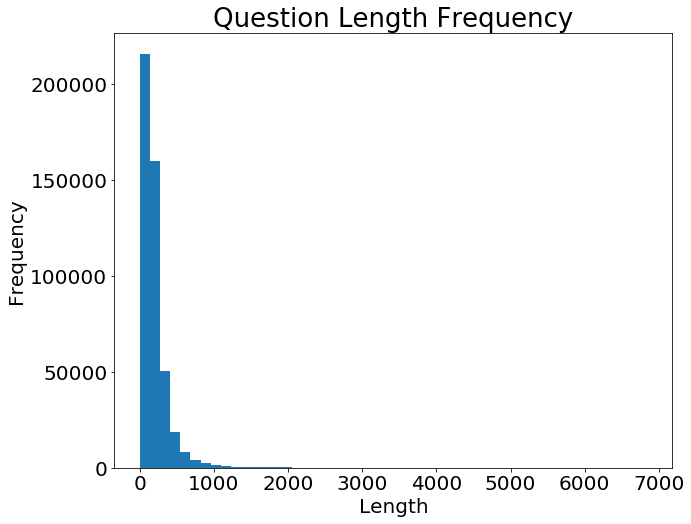

In [299]:
# Histogram of Question Length Frequency 

plt.figure(figsize=(10,8))

plt.hist(x = df['length'], bins = 50)

plt.xticks(fontsize = 20);
plt.yticks(fontsize = 20);

plt.title('Question Length Frequency', fontsize = 26)
plt.xlabel('Length', fontsize=20)
plt.ylabel('Frequency', fontsize=20);

## Most Frequent Words 
    - For all corpus 
    - Language Specific 
        - SQL
        - Scala 
        - R
        - Julia
        - C++
        - Python

### Most Frequent Words (ALL) 
    - Bar graph 
    - Word Cloud

In [311]:
X = df['body_clean']
y = df['target_class']

In [312]:
cvec = CountVectorizer(stop_words='english', 
                       max_features = 100,    # Top 500 words used
                       ngram_range = (1,1))    #can try bi-grams next 
#                      max_df = 0.9,  # max_df of 0.9 will ignore words that occur in over 90% of your corpus.
#                      min_df = 10   # min_df of 0.1 will ignore words that occur in less than 10% of your corpus

# Sparse Matrix
sparse_cv = cvec.fit_transform(X)

In [313]:
# CVEC Dataframe
cvec_df = pd.DataFrame(sparse_cv.toarray(), columns=cvec.get_feature_names())

In [314]:
cvec_df.head()

,add,app,array,class,code,column,columns,com,count,create,csv,data,database,dataframe,date,db,def,df,end,error,example,false,file,files,following,frame,function,group,help,id,image,import,include,index,input,int,just,key,know,lib,like,line,list,main,make,max,model,models,na,need,new,np,null,number,object,open,order,output,packages,path,print,problem,py,python,query,read,request,result,return,row,run,select,self,server,set,site,size,sql,start,std,str,string,table,test,text,time,tried,true,trying,type,url,use,user,users,using,value,values,want,way,work
0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2,0,0
1,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,5,0,0,0,14,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,1,0,0
2,2,0,3,2,4,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,4,0,0,0,0,0,0,0,0,8,0,0,0,1,1,0,0,3,0,4,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,3,0,0,0,4,8,0,0,0,1,1,0,1,0,1,0,2,3,1,0,1,0,1,0,0,0,0,5,1,1,1,0,0,1,0,1,0,0,0,1,0,0
3,0,0,4,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,9,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,2,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,14,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [315]:
sum_words = cvec_df.sum(axis=0) 

In [316]:
# can't add index because sum_words.sort_values --> series ??
top_words = pd.DataFrame(sum_words.sort_values(ascending = False), columns = ['count'])

In [317]:
top_words

,count
data,547115
self,469186
id,449011
file,406416
code,335646
...,...
know,79224
group,76934
make,76743
order,75240


In [319]:
# need to reset index to use for word clouds (but don't need index for bargraphs...)
top_words.reset_index(inplace = True)

In [320]:
top_words

,index,count
0,data,547115
1,self,469186
2,id,449011
3,file,406416
4,code,335646
...,...,...
95,know,79224
96,group,76934
97,make,76743
98,order,75240


#### Word Cloud

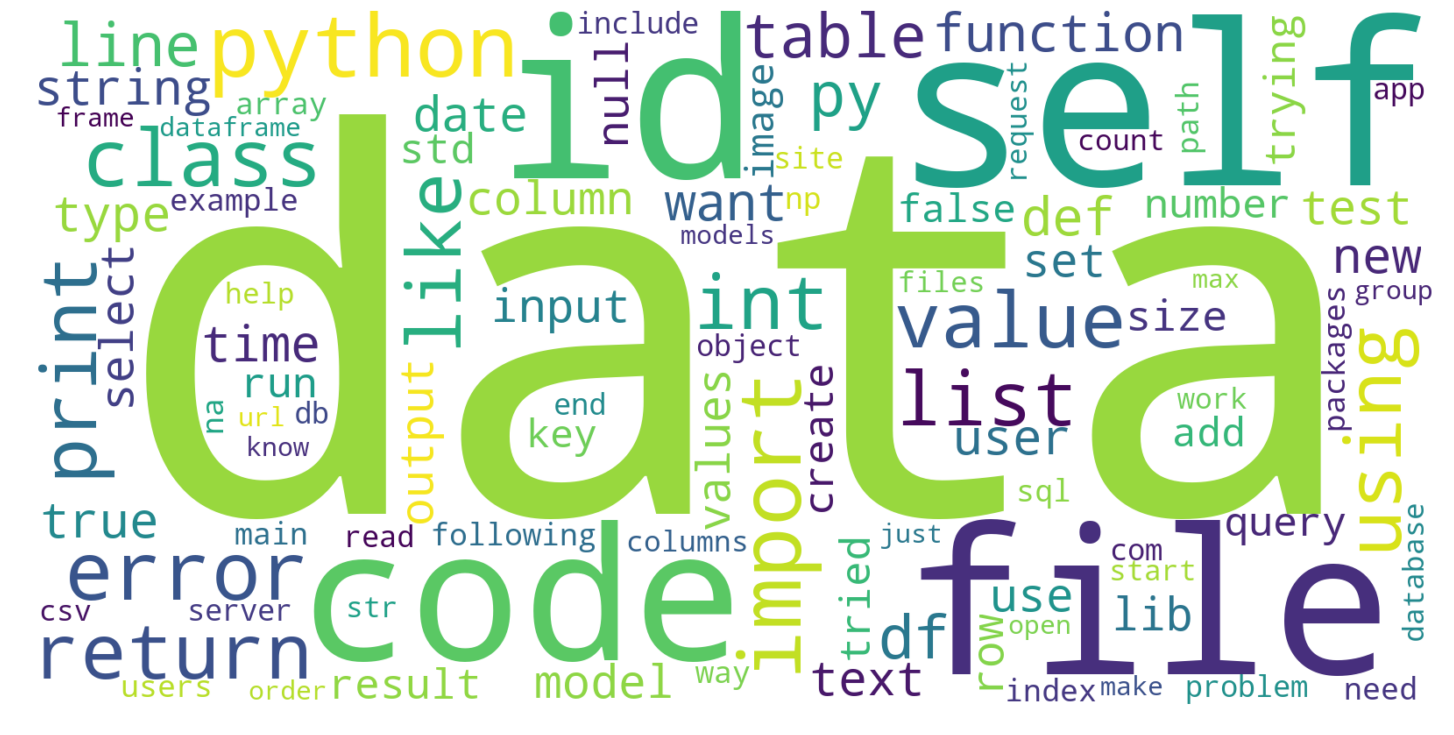

In [322]:
####### THIS IS THE RIGHT FORMATT FOR WORD CLOUDS!!!!! *************
# empty dictionary 
d = {}

# where top_words is a pandas DataFrame with columns words and counts
for a, x in top_words.values:
    d[a] = x


wordcloud = WordCloud(max_words=250,
                      max_font_size= 600,
                      background_color="white", 
                      width=1600, height=800)

wordcloud.generate_from_frequencies(frequencies=d)

plt.figure(figsize=(20,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
# plt.show();
plt.savefig('../images/wordcloud_topwords10.png',bbox_inches='tight')

#### Bargraph Top 15

In [323]:
top15 = top_words.iloc[0:15,:]

In [324]:
top15

,index,count
0,data,547115
1,self,469186
2,id,449011
3,file,406416
4,code,335646
5,python,321767
6,import,314989
7,error,282213
8,class,269461
9,using,253231


In [184]:
top15.sort_values('count')

,index,count
14,like,243006
13,list,243098
12,print,246254
11,value,249897
10,return,252029
9,using,253231
8,class,269461
7,error,282213
6,import,314989
5,python,321767


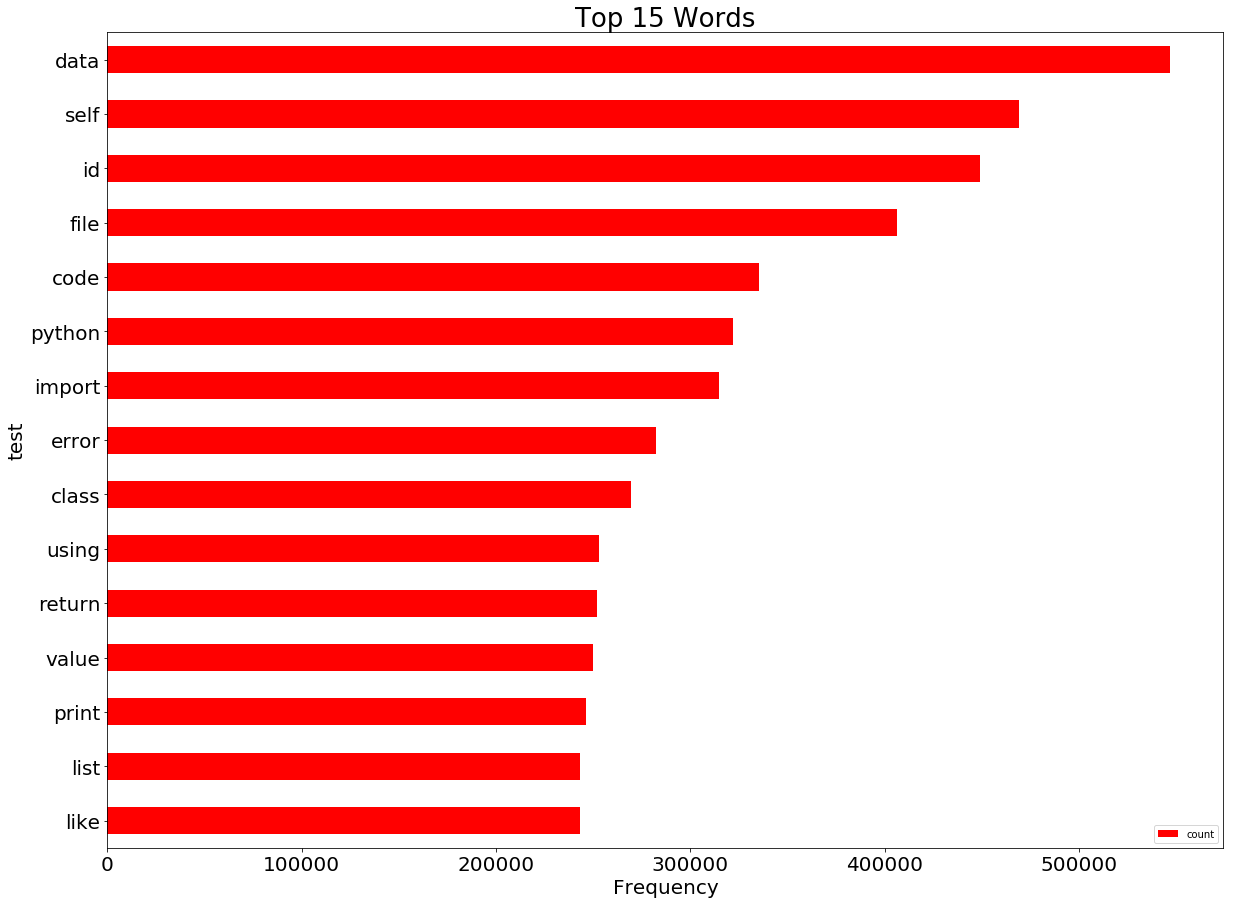

In [189]:
# Sort values by count
top15.sort_values('count', ascending = True).set_index('index', inplace = False).plot(kind = 'barh', figsize = (20, 15), color = 'red');
plt.title('Top 15 Words', fontsize=26)
plt.xlabel('Frequency', fontsize=20);
plt.ylabel('test', fontsize = 20);
plt.xticks(fontsize = 20);
plt.yticks(fontsize = 20);

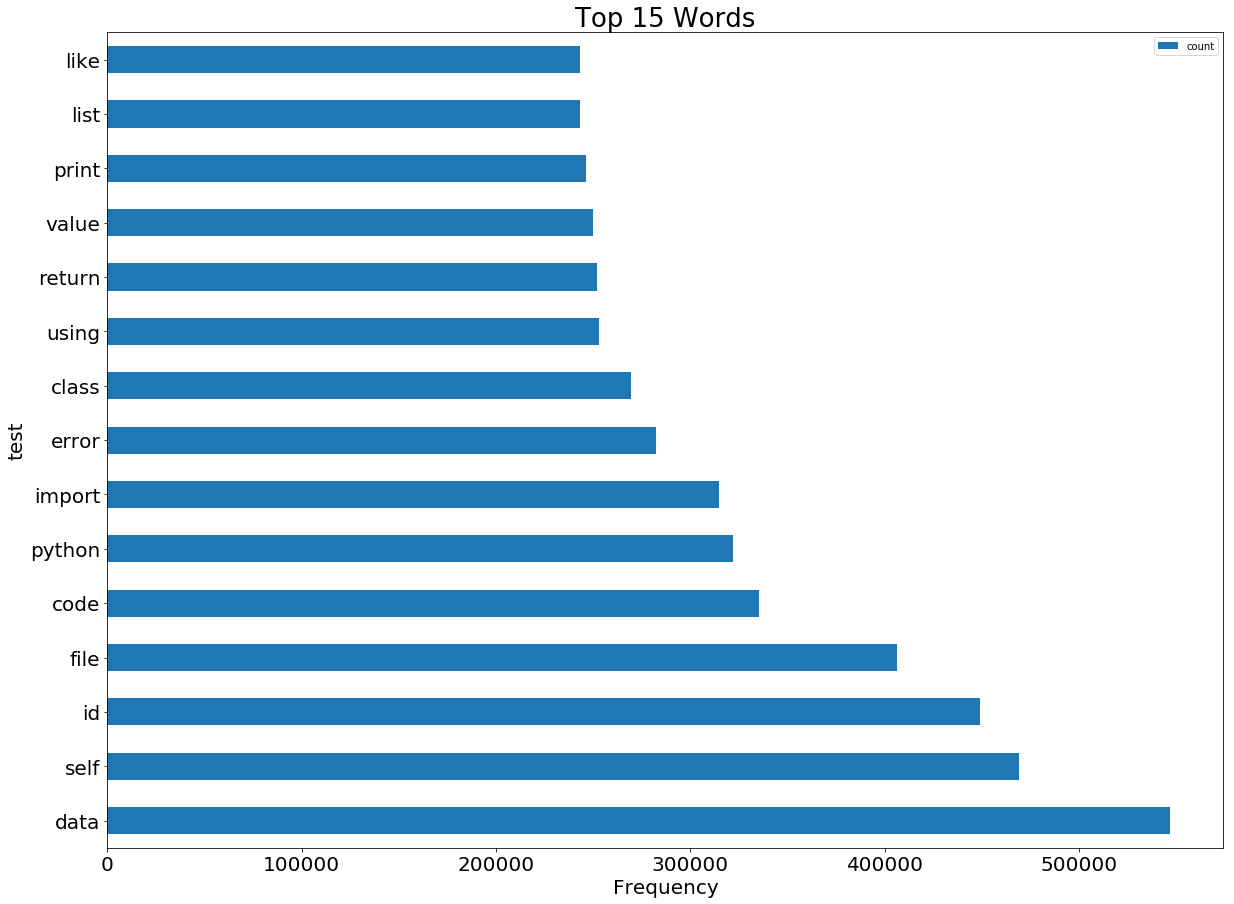

In [188]:
# plt.figure(figsize=(100,9));
# plt.bar(y = top15['count'], x = top15['index'], height = ])

# ****** remove .reset index and wont need to add .set_index for plotting******
top15.sort_values('count', ascending = False).set_index('index', inplace = False).plot(kind = 'barh', 
                                                                                       figsize = (20, 15));
plt.title('Top 15 Words', fontsize=26)
plt.xlabel('Frequency', fontsize=20);
plt.ylabel('test', fontsize = 20);
plt.xticks(fontsize = 20);
plt.yticks(fontsize = 20);

##  Function 

In [306]:
def freq_words(df):
    '''
    function that takes in dataframe:
        - splits into X, y 
        - creates CountVectorizer instance 
        - takes sparse matrix --> dataframe (sum of total times certain word used)
        - returns the above dataframe 
    Returns: Dataframe, with word: frequency 
    
    '''
    X = df['body_clean']
    y = df['target_class']
    
    cvec = CountVectorizer(stop_words='english', 
                           max_features = 100,   
                           ngram_range = (1,1))    #can try bi-grams next 

    # Sparse Matrix
    sparse_cv = cvec.fit_transform(X)

    # Sparse matrix --> Dataframe
    cvec_df = pd.DataFrame(sparse_cv.toarray(), columns=cvec.get_feature_names())

    # Total times word was used 
    sum_words = cvec_df.sum(axis=0) 
    
    # Dataframe 
    top_words = pd.DataFrame(sum_words.sort_values(ascending = False), columns = ['count'])
    
    # Reset index
    top_words = top_words.reset_index()
    
    # Change Column name from index --> word 
    top_words = top_words.rename(columns={'index': 'word'})
    
    return top_words

In [307]:
total_frequency = freq_words(df)

In [309]:
total_frequency

pandas.core.frame.DataFrame

In [106]:
total_frequency[0:25]

,word,count
0,data,547115
1,self,469186
2,id,449011
3,file,406416
4,code,335646
5,python,321767
6,import,314989
7,error,282213
8,class,269461
9,using,253231


### Most Frequent Words: SQL

In [91]:
sql_df = df[df['target_class'] == 0]

In [93]:
sql_frequency = freq_words(sql_df)

In [108]:
sql_frequency[0:25]

,count
id,263760
table,170432
select,129408
data,98185
query,97987
null,94952
date,86940
sql,84863
user,69161
database,67490


### Most Frequent Words: Scala

In [109]:
scala_df = df[df['target_class'] == 1]

In [110]:
scala_frequency = freq_words(scala_df)

In [112]:
scala_frequency[0:25]

,word,count
0,scala,28407
1,val,17905
2,spark,17613
3,org,15901
4,string,13671
5,java,12935
6,apache,12203
7,error,9670
8,class,8161
9,case,7566


### Most Frequent Words: R

In [85]:
r_df = df[df['target_class'] == 2]

In [111]:
r_frequency = freq_words(r_df)

In [113]:
r_frequency[0:25]

,word,count
0,data,126947
1,na,98776
2,df,58318
3,function,40924
4,list,39319
5,frame,34724
6,like,33810
7,code,31247
8,library,31181
9,id,29291


### Most Frequent Words: Julia

In [118]:
julia_df = df[df['target_class'] == 3]

In [119]:
julia_frequency = freq_words(julia_df)
julia_frequency[0:25]

,word,count
0,julia,2973
1,jl,1860
2,end,1708
3,function,1417
4,array,1390
5,int,1257
6,using,1103
7,error,950
8,float,945
9,code,782


### Most Frequent Words: C++

In [120]:
cplus_df = df[df['target_class'] == 4]

In [121]:
cplus_frequency = freq_words(cplus_df)
cplus_frequency[0:25]

,word,count
0,int,139511
1,std,122450
2,include,66846
3,return,53243
4,cout,52398
5,void,49041
6,const,48961
7,string,48576
8,class,47660
9,code,45217


### Most Frequent Words: Python

In [325]:
python_df = df[df['target_class'] == 5]

In [336]:
python_frequency = freq_words(python_df)
python_frequency.head()

,word,count
0,self,454260
1,file,308363
2,python,303145
3,import,289393
4,data,285810


#### Bargraph

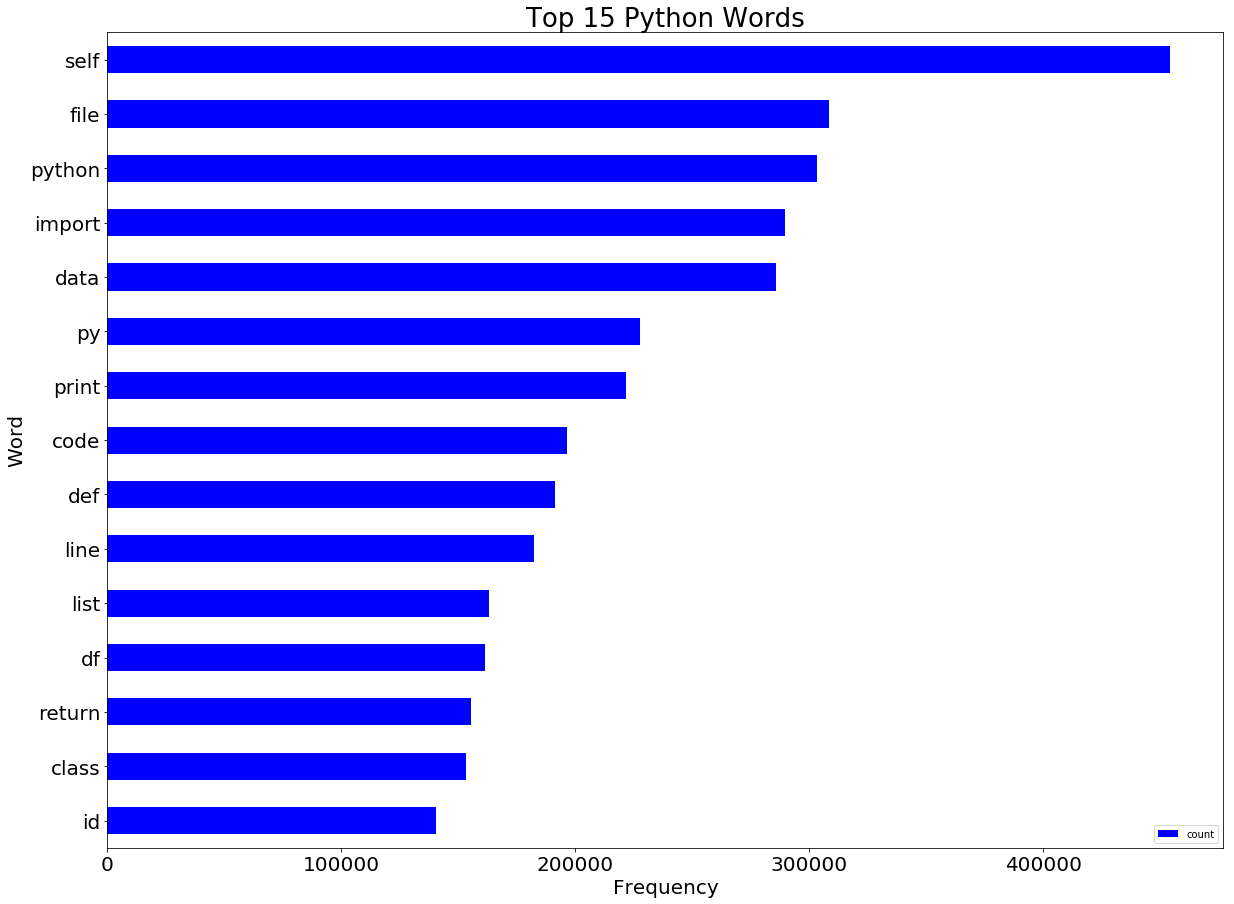

In [334]:
python_frequency[0:15].sort_values('count', ascending = True).set_index('word', inplace = False).plot(kind = 'barh', figsize = (20, 15), color = 'blue');

plt.title('Top 15 Python Words', fontsize=26)
plt.xlabel('Frequency', fontsize=20);
plt.ylabel('Word', fontsize = 20);
plt.xticks(fontsize = 20);
plt.yticks(fontsize = 20);

## Most Frequent Bi-words

### Function 

In [341]:
def freq_biwords(df):
    '''
    function that takes in dataframe:
        - splits into X, y 
        - creates CountVectorizer instance (bigrams)
        - takes sparse matrix --> dataframe (sum of total times certain word used)
        - returns the above dataframe 
    Returns: Dataframe, with word: frequency 
    
    '''
    X = df['body_clean']
    y = df['target_class']
    
    cvec_bi = CountVectorizer(stop_words='english', 
                           max_features = 100,   
                           ngram_range = (1,2))    

    # Sparse Matrix
    sparse_bi_cv = cvec_bi.fit_transform(X)

    # Sparse matrix --> Dataframe
    cvec_bi_df = pd.DataFrame(sparse_bi_cv.toarray(), columns=cvec_bi.get_feature_names())

    # Total times word was used 
    sum_bi_words = cvec_bi_df.sum(axis=0) 
    
    # Dataframe 
    top_biwords = pd.DataFrame(sum_bi_words.sort_values(ascending = False), columns = ['count'])
    
    # Reset index
    top_biwords = top_biwords.reset_index()
    
    # Change Column name from index --> word 
    top_biwords = top_biwords.rename(columns={'index': 'word'})
    
    return top_biwords

### Top Bi-Grams

In [344]:
X = df['body_clean']
y = df['target_class']

In [345]:
cvec_bi = CountVectorizer(stop_words='english', 
                           max_features = 100,   
                           ngram_range = (1,2))  

In [346]:
sparse_bi_cv = cvec_bi.fit_transform(X)

In [350]:
cvec_bi.get_feature_names()

['add',
 'app',
 'array',
 'class',
 'code',
 'column',
 'columns',
 'com',
 'count',
 'create',
 'csv',
 'data',
 'database',
 'dataframe',
 'date',
 'db',
 'def',
 'df',
 'end',
 'error',
 'example',
 'false',
 'file',
 'files',
 'following',
 'frame',
 'function',
 'group',
 'help',
 'id',
 'image',
 'import',
 'include',
 'index',
 'input',
 'int',
 'just',
 'key',
 'know',
 'lib',
 'like',
 'line',
 'list',
 'main',
 'make',
 'max',
 'model',
 'models',
 'na',
 'need',
 'new',
 'np',
 'null',
 'number',
 'object',
 'output',
 'packages',
 'path',
 'print',
 'problem',
 'py',
 'py line',
 'python',
 'query',
 'read',
 'request',
 'result',
 'return',
 'row',
 'run',
 'select',
 'self',
 'server',
 'set',
 'site',
 'site packages',
 'size',
 'sql',
 'start',
 'std',
 'str',
 'string',
 'table',
 'test',
 'text',
 'time',
 'tried',
 'true',
 'trying',
 'type',
 'url',
 'use',
 'user',
 'users',
 'using',
 'value',
 'values',
 'want',
 'way',
 'work']

In [352]:
cvec_bi_df = pd.DataFrame(sparse_bi_cv.toarray(), columns=cvec_bi.get_feature_names())
cvec_bi_df

,add,app,array,class,code,column,columns,com,count,create,csv,data,database,dataframe,date,db,def,df,end,error,example,false,file,files,following,frame,function,group,help,id,image,import,include,index,input,int,just,key,know,lib,like,line,list,main,make,max,model,models,na,need,new,np,null,number,object,output,packages,path,print,problem,py,py line,python,query,read,request,result,return,row,run,select,self,server,set,site,site packages,size,sql,start,std,str,string,table,test,text,time,tried,true,trying,type,url,use,user,users,using,value,values,want,way,work
0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2,0,0
1,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,5,0,0,0,14,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,1,0,0
2,2,0,3,2,4,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,4,0,0,0,0,0,0,0,0,8,0,0,0,1,1,0,0,3,0,4,0,0,0,0,0,0,0,0,0,3,0,1,0,0,3,0,0,0,4,4,8,0,0,0,1,1,0,1,0,1,0,2,3,3,1,0,1,0,1,0,0,0,0,5,1,1,1,0,0,1,0,1,0,0,0,1,0,0
3,0,0,4,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,9,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,2,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,14,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465049,0,0,0,0,0,2,1,0,0,0,0,2,0,1,0,0,0,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
465050,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,8,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
465051,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1
465052,0,0,0,0,1,1,0,0,0,0,0,3,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6,2,0,0


### SQL

In [342]:
sql_bifreq = freq_biwords(sql_df)
sql_bifreq.head()

,word,count
0,id,263760
1,table,170432
2,select,129408
3,data,98185
4,query,97987
